In [1]:
import pandas as pd
from elasticsearch import Elasticsearch, helpers
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.gui import tqdm as tqdm_gui


AJout des functions d'import des data

In [2]:
def xmlToDf(xmlFile):
    # Read XML file
    df = pd.read_xml(xmlFile)
    # replace comma to point in note column
    df["note"] = df["note"].apply(lambda x: x.replace(",", "."))
    df["commentaire"] = df["commentaire"].apply(checkIfWordInComment)
    # string to double conversion column
    df['note'] = df['note'].astype(float)
    return df

def checkIfWordInComment(comment):
    if comment is None:
        return ""
    return comment

def getNbUpperCases(comment):
    if comment is None:
        return 0
    return sum(1 for c in comment if c.isupper())

def getSizeString(comment):
    if comment is None:
        return 0
    return int(len(comment))

def getCountWords(comment):
    if comment is None:
        return 0
    return int(len(comment.split()))

def getCountExclamation(comment):
    if comment is None:
        return 0
    return int(comment.count('!'))

def getCountQuestion(comment):
    if comment is None:
        return 0
    return int(comment.count('?'))

def getCountPoint(comment):
    if comment is None:
        return 0
    return int(comment.count('.'))
    
def getCountSmiley(comment):
    if comment is None:
        return 0
    return int(comment.count(':)'or ':(' or ':D' or 'xD'))

def getCountPas(comment):
    if comment is None:
        return 0
    return int(comment.lower().count('pas'))

def getCountGoodList(comment):
    if comment is None:
        return 0
    count = 0
    for word in good_list:
        count += comment.lower().count(word)
    return count

def getCountBadList(comment):
    if comment is None:
        return 0
    count = 0
    for word in bad_list:
        count += comment.lower().count(word)
    return count

def getClassRate(note):
    if note < 2:
        return 0
    elif note > 2:
        return 2
    else:
        return 1

def loadGoodList():
    with open('../Projet/dict/good.txt', 'r') as f:
        return f.read().splitlines()

def loadBadList():
    with open('../Projet/dict/bad.txt', 'r') as f:
        return f.read().splitlines()

def loadAndGetBasicInfo(path):
    df_dev = xmlToDf(path)
    df_dev['class_rate'] = df_dev['note'].apply(getClassRate)    
    df_dev['size_char'] = df_dev['commentaire'].apply(getSizeString)
    print("Got size_char")
    df_dev['uppercase'] = df_dev['commentaire'].apply(getNbUpperCases)
    print('Got uppercase')
    df_dev['ratio'] = df_dev['size_char']/df_dev['uppercase']
    print('Got ratio')
    df_dev['count_words'] = df_dev['commentaire'].apply(getCountWords)
    print('Got count_words')
    df_dev['count_exclamation'] = df_dev['commentaire'].apply(getCountExclamation)
    print('Got count_exclamation')
    df_dev['count_question'] = df_dev['commentaire'].apply(getCountQuestion)
    print('Got count_question')
    df_dev['count_point'] = df_dev['commentaire'].apply(getCountPoint)
    print('Got count_point')
    df_dev['count_smiley'] = df_dev['commentaire'].apply(getCountSmiley)
    print('Got count_smiley')
    df_dev['count_pas'] = df_dev['commentaire'].apply(getCountPas)
    print('Got count_pas')    
    tqdm.pandas(desc="Counting bad words")
    df_dev['count_mal'] = df_dev['commentaire'].progress_apply(lambda x: getCountBadList(x))
    print('Got count_mal')    
    tqdm.pandas(desc="Counting good words")
    df_dev['count_good'] = df_dev['commentaire'].progress_apply(lambda x: getCountGoodList(x))
    print('Got count_mal')
    return df_dev

bad_list = loadBadList()
good_list = loadGoodList()

Import des data dev


In [3]:
df_dev = loadAndGetBasicInfo("data/dev.xml")
print (df_dev.keys())


KeyboardInterrupt: 

In [3]:
df_train = loadAndGetBasicInfo("data/train.xml")
print (df_train.keys())

Got size_char
Got uppercase
Got ratio
Got count_words
Got count_exclamation
Got count_question
Got count_point
Got count_smiley
Got count_pas


Counting bad words: 100%|██████████| 665962/665962 [00:16<00:00, 40415.08it/s]


Got count_mal


Counting good words: 100%|██████████| 665962/665962 [00:16<00:00, 40445.88it/s]

Got count_mal
Index(['movie', 'review_id', 'name', 'user_id', 'note', 'commentaire',
       'class_rate', 'size_char', 'uppercase', 'ratio', 'count_words',
       'count_exclamation', 'count_question', 'count_point', 'count_smiley',
       'count_pas', 'count_mal', 'count_good'],
      dtype='object')


Import des data via deserialize

In [10]:
def deserializeDf(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
    
# df_dev = deserializeDf('data/df_dev.pkl')
# df_idf = deserializeDf('data/df_idf.pkl')
df_train = deserializeDf('data/df_train.pkl')
#df_idf_train = deserializeDf('data/df_idf_train.pkl')

Separation de la data en 3 classes (0.5-1.5 / 2 / 2.5-5)

In [5]:
df_low = df_dev.loc[df_dev['note'] < 2]
df_mid = df_dev.loc[(df_dev['note'] == 2)]
df_high = df_dev.loc[df_dev['note'] > 2]
df_dev['class_rate'] = df_dev['note'].apply(getClassRate) 

Des graphs

<AxesSubplot: xlabel='note'>

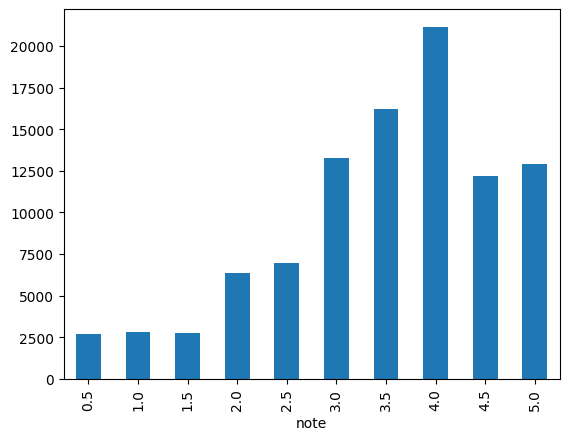

In [7]:
# mean CountBien by note
df_dev.groupby('note')['count_good'].sum().plot(kind='bar')

<AxesSubplot:title={'center':'CountPas by note'}, xlabel='class_rate', ylabel='count_pas'>

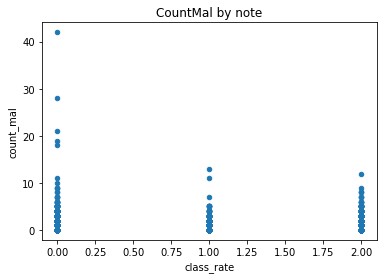

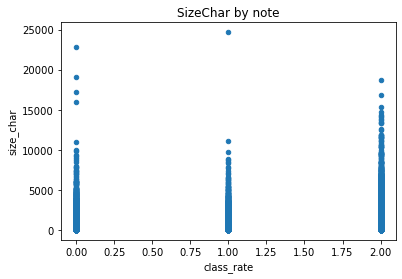

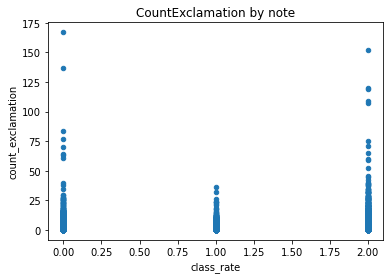

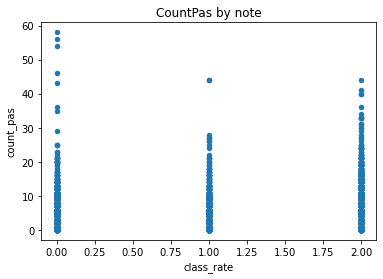

In [61]:
df_dev.plot(x='class_rate', y='count_mal', kind='scatter', title='CountMal by note')
df_dev.plot(x='class_rate', y='size_char', kind='scatter', title='SizeChar by note')
df_dev.plot(x='class_rate', y='count_exclamation', kind='scatter', title='CountExclamation by note')
df_dev.plot(x='class_rate', y='count_pas', kind='scatter', title='CountPas by note')

<AxesSubplot:title={'center':'Note par Classe distribution'}, ylabel='class_rate'>

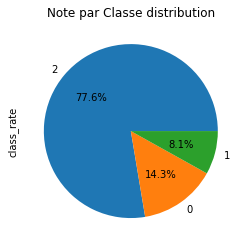

In [21]:
df_dev['class_rate'].value_counts().plot(kind='pie', title='Note par Classe distribution', xlabel='ClassRate', autopct='%1.1f%%')

<AxesSubplot:title={'center':'Note distribution'}, ylabel='note'>

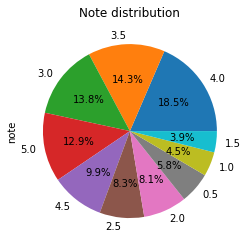

In [20]:
df_dev['note'].value_counts().plot(kind='pie', title='Note distribution', xlabel='Note', autopct='%1.1f%%')

Normalisation + stemming

In [6]:
def TfIdf(df, column):
    from sklearn.feature_extraction.text import TfidfVectorizer
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df[column])
    return X

x = TfIdf(df_dev, 'commentaire')
print(x)

  (0, 19757)	0.18687771683382542
  (0, 48901)	0.19070082913350986
  (0, 83973)	0.03842537283589266
  (0, 19314)	0.12576934176003657
  (0, 88498)	0.10989720432141713
  (0, 32824)	0.07478572548905398
  (0, 61769)	0.07723367066740257
  (0, 71022)	0.135551918556739
  (0, 79063)	0.09634334825587375
  (0, 68853)	0.031621853764034064
  (0, 90127)	0.05416056160163361
  (0, 58850)	0.08835171409701363
  (0, 71831)	0.11924719046445877
  (0, 92322)	0.02717659835194249
  (0, 88448)	0.08192120620741246
  (0, 92287)	0.022038799711691436
  (0, 46918)	0.127714871290098
  (0, 76354)	0.1209863061717123
  (0, 66526)	0.05101464405073643
  (0, 63071)	0.030983157942342035
  (0, 47014)	0.18687771683382542
  (0, 97566)	0.1209132443451202
  (0, 64725)	0.09564533630715794
  (0, 33424)	0.15676038569827785
  (0, 21448)	0.09448442761009675
  :	:
  (100399, 72074)	0.061359460769206585
  (100399, 2636)	0.07123186957143746
  (100399, 8753)	0.05516281640257527
  (100399, 68853)	0.10107447111897357
  (100399, 92322)	0.0

In [7]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

#instantiate CountVectorizer() 
cv=CountVectorizer() 
# this steps generates word counts for the words in your docs 

word_count_vector=cv.fit_transform(df_dev['commentaire'])
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names_out(),columns=["idf_weights"]) 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
de,1.219785
et,1.247718
un,1.286338
film,1.310228
le,1.341365
...,...
inerent,11.823780
inerprété,11.823780
inerprétée,11.823780
indétronâble,11.823780


In [5]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

#instantiate CountVectorizer() 
cv=CountVectorizer() 
# this steps generates word counts for the words in your docs 

word_count_vector=cv.fit_transform(df_train['commentaire'])
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)
# print idf values 
df_idf_train = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names_out(),columns=["idf_weights"]) 
# sort ascending 
df_idf_train.sort_values(by=['idf_weights'])

,idf_weights
de,1.217917
et,1.244742
un,1.279303
film,1.308810
le,1.338168
...,...
ilustrées,13.715842
ilétéoùheinoussama,13.715842
im6,13.715842
imersif,13.715842


trie des stopwords + Stemming des mots

In [7]:
import spacy
import nltk
import multiprocessing as mp

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='french')
nltk.download('stopwords')
stopWords = set(stopwords.words('french'))
nlp = spacy.load("fr_core_news_sm")

def getStemWord(comment):
    if comment is None:
        return ""
    doc = nlp(comment)
    tokens = [X.text for X in doc]
    clean_words = []
    for token in tokens:
        if token not in stopWords:
            clean_words.append(token)
    return [stemmer.stem(token) for token in clean_words]

def getProperName(comment):
    if comment is None:
        return ""
    doc = nlp(comment)
    return [(X.text, X.label_) for X in doc.ents]


tqdm.pandas(desc="Stemming words")
df_train['stem_word'] = df_train['commentaire'].progress_apply(lambda x: getStemWord(x))
df_train['proper_name'] = df_train['commentaire'].progress_apply(lambda x: getProperName(x))
# df_dev['stem_word'] = df_dev['commentaire'].progress_apply(lambda x: getStemWord(x))
# df_dev['proper_name'] = df_dev['commentaire'].progress_apply(lambda x: getProperName(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wiakx\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Stemming words: 100%|██████████| 665962/665962 [1:34:30<00:00, 117.45it/s] 


Redivision des données en classe selon les notes

In [8]:
df_low = df_dev.loc[df_dev['note'] < 2]
df_mid = df_dev.loc[(df_dev['note'] == 2)]
df_high = df_dev.loc[df_dev['note'] > 2]


def dictFreqEachWords(df):
    dictFreq = {}
    for index, row in df.iterrows():
        for word in row['stem_word']:
            if word in dictFreq:
                dictFreq[word] += 1
            else:
                dictFreq[word] = 1
    return dictFreq

def OrderDictByValue(dictFreq):
    return {k: v for k, v in sorted(dictFreq.items(), key=lambda item: item[1], reverse=True)}

def PrintXFirstDict(dictFreq, x):
    for key, value in dictFreq.items():
        if x > 0:
            print(key, value)
            x -= 1
        else:
            break
    return

dict_low = dictFreqEachWords(df_low)
dict_mid = dictFreqEachWords(df_mid)
dict_high = dictFreqEachWords(df_high)
dict_low = OrderDictByValue(dict_low)
dict_mid = OrderDictByValue(dict_mid)
dict_high = OrderDictByValue(dict_high)

print('-----------------')
print('Low\n')
PrintXFirstDict(dict_low, 10)
print('-----------------')
print('Mid\n')
PrintXFirstDict(dict_mid, 10)
print('-----------------')
print('High\n')
PrintXFirstDict(dict_high, 10)

print('-----------------')
print('End')

-----------------
Low

, 65003
. 53775
film 23133
! 15705
d' 15523
l' 15518
a 13247
" 11370
c' 9739
... 9619
-----------------
Mid

, 42438
. 34898
film 13736
l' 10629
d' 9512
a 7670
" 7034
plus 5683
tout 5548
! 5457
-----------------
High

, 375462
. 320961
film 136172
l' 100379
d' 88764
! 67648
a 63611
" 55377
bien 50641
tout 50013
-----------------
End


In [7]:
plt.figure(figsize=(20,5))
plt.plot(list(dict_low.keys())[:30], list(dict_low.values())[:30], label='Low')
plt.title('Low')
plt.show()
plt.figure(figsize=(20,5))
plt.plot(list(dict_mid.keys())[:30], list(dict_mid.values())[:30], label='Mid')
plt.title('Mid')
plt.show()
plt.figure(figsize=(20,5))
plt.plot(list(dict_high.keys())[:30], list(dict_high.values())[:30], label='High')
plt.title('High')
plt.show()

NameError: name 'dict_low' is not defined

<Figure size 2000x500 with 0 Axes>

Supression des mots parmis les 30 premiers du dico Dict_High qui sont aussi parmis les 30 premiers mots des autres dico


Relancer les graphs juste au dessus pour voir la difference et les vraies differences

In [11]:
def removeSimilarInDicts():
    listWord = list(dict_high.keys())[:30]
    for i in range(0, 30):
        if listWord[i] in list(dict_mid.keys())[:30] or listWord[i] in list(dict_low.keys())[:30]:
            dict_high.pop(listWord[i])
            dict_low.pop(listWord[i])
            dict_mid.pop(listWord[i])
            
removeSimilarInDicts()

NameError: name 'dict_high' is not defined

Serialize df into file (pour save)

In [29]:
def serializeDf(df, path):
    with open(path, 'wb') as f:
        pickle.dump(df, f)
        
serializeDf(df_dev, 'data/df_dev.pkl')
serializeDf(df_idf, 'data/df_idf.pkl')

In [1]:
def serializeDf(df, path):
    with open(path, 'wb') as f:
        pickle.dump(df, f)
        
serializeDf(df_train, 'data/df_train.pkl')
#serializeDf(df_idf_train, 'data/df_idf_train.pkl')

NameError: name 'df_train' is not defined

In [10]:
def removeCommaInDF():
    for index, row in df_train.iterrows():
        if row['stem_word'].count(',') > 0:
            row['stem_word'].remove(',')

removeCommaInDF()
print(df_train['stem_word'][:10])

NameError: name 'df_dev' is not defined

In [11]:
def listToString(s):  
    str1 = " " 
    return (str1.join(s))

df_train['stem_word_string'] = df_train['stem_word'].apply(lambda x: listToString(x))

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

#instantiate CountVectorizer() 
cv=CountVectorizer() 
# this steps generates word counts for the words in your docs 

word_count_vector=cv.fit_transform(df_train['stem_word_string'])
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)
# print idf values 
df_idf_train = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names_out(),columns=["idf_stem_weights"]) 
# sort ascending 
df_idf_train.sort_values(by=['idf_stem_weights'])

,idf_stem_weights
film,1.276222
bien,1.971428
tout,2.002309
tres,2.011759
bon,2.025595
...,...
hypeee,13.715842
hype,13.715842
hypcondriaqu,13.715842
hypercar,13.715842


In [15]:
from multiprocessing import Pool
from tqdm.contrib.concurrent import process_map

def stemWordLow(stem_word):
    if stem_word is None:
        return []
    clean_words = []
    for token in stem_word:
        if token in df_idf_train.index and df_idf_train.loc[token]['idf_stem_weights'] < 11:
            clean_words.append(token)
    return clean_words

def removeUselessWords():
    df_train['stem_word_low'] = df_train['stem_word'].apply(lambda x: stemWordLow(x))

removeUselessWords()

NameError: name 'df_idf' is not defined

In [5]:
print(len(df_train['stem_word'][14274]))
print(len(df_train['stem_word_low'][14274]))
print(len(df_train['stem_word_string'][14274].split(' ')))

65
54
65


In [25]:
print(len(df_dev['stem_word'][14274]))
print(len(df_dev['stem_word_low'][14274]))
print(len(df_dev['stem_word_string'][14274].split(' ')))
print('только' in df_idf.index and df_idf.loc['только']['idf_stem_weights'] < 11.0)

383
132
391
False


In [8]:
def create_dict_of_words():
    word_to_id = {}
    index = 0
    # for comment in df_dev['stem_word_low']:
    for comment in df_train['stem_word_low']:
        for token in comment:
            if token not in word_to_id:
                word_to_id[token] = index
                index += 1
    return word_to_id


In [11]:
word_to_id = create_dict_of_words()

In [2]:
def comment_to_vec(comment):
    vector = [0] * len(word_to_id)
    for token in comment:
        vector[word_to_id[token]] += 1
    return vector

def vector_to_svm(vector):
    svm = ''
    for i in range(len(vector)):
        if vector[i] > 0:
            svm += str(i+1) + ':' + str(vector[i]) + ' '
    return svm

def comment_to_svm(comment, note):
    dict_comment = {}
    for token in comment:
        dict_comment[token] = dict_comment.get(token, 0) + 1
    svm = '' + str(note*2) + ' '
    #sort by key with word_to_id
    dict_comment = {k: v for k, v in sorted(dict_comment.items(), key=lambda item: word_to_id[item[0]])}
    for token in dict_comment:
        svm += str(word_to_id[token]+1) + ':' + str(dict_comment[token]) + ' '
    return svm

def comment_to_svm_class(comment, note):
    dict_comment = {}
    for token in comment:
        if (word_to_id.get(token) is not None):
            dict_comment[token] = dict_comment.get(token, 0) + 1
    if note < 2:
        svm = '' + str(1) + ' '
    elif note == 2:
        svm = '' + str(2) + ' '
    else:
        svm = '' + str(3) + ' '
    #sort by key with word_to_id
    dict_comment = {k: v for k, v in sorted(dict_comment.items(), key=lambda item: word_to_id[item[0]])}
    for token in dict_comment:
        svm += str(word_to_id[token]+1) + ':' + str(dict_comment[token]) + ' '
    return svm

In [13]:
comment_low_train = df_train['stem_word_low'].values.tolist()
note_train = df_train['note'].values.tolist()
del(df_train)
#del(df_idf_train)

In [4]:
import tqdm

svms = []

tqdm.pandas(desc="Converting to svm")
for index, comment in enumerate(tqdm(comment_low_train)):
    svm = comment_to_svm(comment, note_train[index])
    svms.append(svm)

NameError: name 'tqdm' is not defined

In [33]:
svms = []
for index, comment in enumerate(tqdm(comment_low_train)):
    svm = comment_to_svm_class(comment, note_train[index])
    svms.append(svm)


























































































































































































































































































































































100%|██████████| 665962/665962 [00:37<00:00, 17922.99it/s]


In [15]:
# save svms in svm file
with open('data/SVM_TRAIN_10.svm', 'w') as f:
    for svm in svms:
        f.write(svm + '\n')

In [48]:
svmsC = []
for i ,vector in enumerate(tqdm(vectors)):
    if(df_dev['note'][i] < 2):
        svm = str(1) + ' ' + vector_to_svm(vector)
    elif(df_dev['note'][i] == 2):
        svm = str(2) + ' ' + vector_to_svm(vector)
    else:
        svm = str(3) + ' ' + vector_to_svm(vector)
    svmsC.append(svm)

100%|██████████| 100400/100400 [01:27<00:00, 1142.96it/s]


In [30]:
# save svms in svm file
with open('data/svmsT.svm', 'w') as f:
    for svm in svms:
        f.write(svm + '\n')


<h1>Pour les tests</h1>

In [16]:
import spacy
import nltk
import multiprocessing as mp

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='french')
nltk.download('stopwords')
stopWords = set(stopwords.words('french'))
nlp = spacy.load("fr_core_news_sm")

def getStemWord(comment):
    if comment is None:
        return ""
    doc = nlp(comment)
    tokens = [X.text for X in doc]
    clean_words = []
    for token in tokens:
        if token not in stopWords:
            clean_words.append(token)
    return [stemmer.stem(token) for token in clean_words]

def xmlToDfTest(xmlFile):
    # Read XML file
    df = pd.read_xml(xmlFile)
    df["commentaire"] = df["commentaire"].apply(checkIfWordInComment)
    return df

def checkIfWordInComment(comment):
    if comment is None:
        return ""
    return comment

def stemWordLow(stem_word):
    if stem_word is None:
        return []
    clean_words = []
    for token in stem_word:
        if token in df_idf_train.index and df_idf_train.loc[token]['idf_stem_weights'] < 11:
            clean_words.append(token)
    return clean_words

def comment_to_svm_test(comment):
    dict_comment = {}
    for token in comment:
        if (word_to_id.get(token) is not None):
            dict_comment[token] = dict_comment.get(token, 0) + 1
    svm = '1 '
    #sort by key with word_to_id
    dict_comment = {k: v for k, v in sorted(dict_comment.items(), key=lambda item: word_to_id[item[0]])}
    for token in dict_comment:
        svm += str(word_to_id[token]+1) + ':' + str(dict_comment[token]) + ' '
    return svm

df_test = xmlToDfTest('data/test.xml')
tqdm.pandas(desc="Stemming")
#df_test['stem_word'] = df_test['commentaire'].progress_apply(lambda x: getStemWord(x))

#comment_test = df_test['stem_word'].values.tolist()

#svm_test = []
#for index, comment in enumerate(tqdm(comment_test)):
#    svm = comment_to_svm_test(comment)
#    svm_test.append(svm)


# save svms in svm file
#with open('data/svm_test.svm', 'w') as f:
#    for svm in svm_test:
#        f.write(svm + '\n')


c:\sdk\python10\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wiakx\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
result = []
with open('data/output10.txt', 'r') as f:
    result = f.readlines()
r = []
for i in range(len(result)):
    tmp = df_test['review_id'][i] + ' ' + str(float(result[i])/2)
    tmp = tmp.replace('\n', '').replace('.', ',')
    r.append(tmp)

with open('data/result10.txt', 'w') as f:
    for i in range(len(r)):
        f.write(r[i] + '\n')


In [ ]:
result = []
with open('data/output10.txt', 'r') as f:
    result = f.readlines()
r = []
for i in range(len(result)):
    tmp = df_test['review_id'][i] + ' ' + str(float(result[i])/2)
    tmp = tmp.replace('\n', '').replace('.', ',')
    r.append(tmp)

with open('data/result10.txt', 'w') as f:
    for i in range(len(r)):
        f.write(r[i] + '\n')


In [17]:
df_test = xmlToDfTest('data/test.xml')
print(df_test.head())

    movie        review_id              name                   user_id  \
0  253727  review_59354742  gimliamideselfes  Z20040827093310567684711   
1  253727  review_62570109            Yetcha  Z20030318104639813779116   
2  253727  review_58180650          TTNOUGAT  Z20071021153249553451578   
3  253727  review_57696986       titicaca120  Z20060317115155370578365   
4  253727  review_57736972           velocio  Z20040630141522227308769   

                                         commentaire  
0  12 jours, un film que j'ai raté à sa sortie et...  
1  Ces lueurs dans ces yeux... Soit ils sont tous...  
2  Il s’agit d’un documentaire sans la moindre ac...  
3  un documentaire magnifique dans cette unité ly...  
4  Un documentaire très intéressant, quand bien m...  
